> title : 제 4회 ETRI 휴먼이해 인공지능 논문경진대회 <br>
> author : hjy <br>

In our study, we used smartphones, smartwatches, sleep sensors, and self-recording apps to collect daily life logs and sleep health records of study participants in 2024.The data collection procedures and methods followed a similar approach to those used in previous studies. Here, we pu﻿blicly provide the following 12 data items, which comprise a total of 700 days' worth of lifelog data, strictly for non-commercial and academic research purposes only.
- mACStatus: Indicates whether the smartphone is currently being charged.
- mActivity: Value calculated by the Google Activity Recognition API.
- mAmbience: Ambient sound identification labels and their respective probabilities.
- mBle: Bluetooth devices around individual subject.
- mGps: Multiple GPS coordinates measured within a single minute using the smartphone.
- mLight: Ambient light measured by the smartphone.
- mScreenStatus: Indicates whether the smartphone screen is in use.
- mUsageStats: Indicates which apps were used on the smartphone and for how long.
- mWifi: Wifi devices around individual subject.
- wHr: Heart rate readings recorded by the smartwatch.
- wLight: Ambient light measured by the smartwatch.
- wPedo: Step data recorded by the smartwatch.

For the purpose of training a learning model to predict sleep health, fatigue, and stress, the following six metrics were derived from sleep sensor data and self-reported survey records. Each metric consists of values categorized into either two levels (0, 1) or three levels (0, 1, 2), depending on the specific metric. The detailed classification criteria for each metric's levels will be provided in a separate document.These
metrics assign a value of 0 for sleep records that do not meet the recommended guidelines.For instance, the first questionnaire metric (Q1) is assigned a value of 1 on days when an
individual’s self-reported sleep quality exceeds their average over the experimental period, and 0 when it
falls below that average. Similarly, the second and third metrics (Q2 and Q3) are assigned a value of 0
on days when the participant’s fatigue and stress levels, respectively, exceed their average, and a value of
1 when these levels are below average.

- Q1: Overall sleep quality as perceived by a subject immediately after waking up.
- Q2: Physical fatigue of a subject just before sleep.
- Q3: Stress level experienced by a subject just before sleep.
- S1: Adherence to sleep guidelines for total sleep time (TST).
- S2: Adherence to sleep guidelines for sleep efficiency (SE).
- S3: Adherence to sleep guidelines for sleep onset latency (SOL, or SL).

수면 건강, 피로, 스트레스 예측을 위한 학습 모델을 훈련시키기 위해, 수면 센서 데이터와 자기 보고식 설문 기록을 기반으로 다음의 6가지 지표를 도출했습니다.
각 지표는 해당 항목에 따라 두 수준(0, 1) 또는 세 수준(0, 1, 2)으로 구분된 값을 가집니다.
각 지표의 세부 분류 기준은 별도의 문서에서 제공될 예정입니다.

- Q1: 기상 직후 본인이 인지한 전반적인 수면의 질
 - 0: 개인 평균 이하
 - 1: 개인 평균 이상
- Q2: 취침 직전 본인이 느낀 신체적 피로 수준
 - 0: 높은 피로 수준
 - 1: 낮은 피로 수준
- Q3: 취침 직전 본인이 느낀 스트레스 수준
 - 0: 높은 스트레스 수준
 - 1: 낮은 스트레스 수준
- S1: 총 수면 시간(TST) 가이드라인을 준수했는지 3LEVELS
 - 0: 가이드라인 미준수
 - 1: 가이드라인 부분적 준수
 - 2: 가이드라인 완전 준수
- S2: 수면 효율(SE) 가이드라인을 준수했는지 여부
- (SE: 잠자리에 누워 있었던 전체 시간 대비, 실제로 잠든 시간의 비율)
 - 0: 가이드라인 미준수
 - 1: 가이드라인 준수
- S3: 수면 잠들기 지연 시간(SOL 또는 SL) 가이드라인을 준수했는지 여부
- (SOL: 잠자리에 누운 순간부터 실제로 잠드는 데까지 걸린 시간)
 - 0: 가이드라인 미준수
 - 1: 가이드라인 준수

### 📦 라이브러리

In [2]:
# import timm
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from tqdm.auto import tqdm
from collections import Counter
from scipy.stats import entropy
# from haversine import haversine  # 설치 필요: pip install haversine

import re
import ast
from tqdm import tqdm  # ← 추가
from math import radians, cos, sin, asin, sqrt
from datetime import time
from datetime import timedelta
from functools import reduce
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seed 고정
SD = 42
random.seed(SD)
np.random.seed(SD)
os.environ['PYTHONHASHSEED'] = str(SD)

warnings.filterwarnings('ignore')

In [4]:
# pandas 옵션
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(1)

In [6]:
def correct_lifelog_date_for_midnight(df, timestamp_col='timestamp', lifelog_col='lifelog_date'):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df[lifelog_col] = pd.to_datetime(df[lifelog_col])

    # 조건: timestamp의 시(hour)가 0~5시인 경우만 하루 차감
    mask = (df[timestamp_col].dt.hour >= 0) & (df[timestamp_col].dt.hour < 6)
    df.loc[mask, lifelog_col] = df.loc[mask, lifelog_col] - pd.Timedelta(days=1)

    # lifelog_date를 문자열로 바꾸는 경우
    df[lifelog_col] = df[lifelog_col].dt.date.astype(str)

    return df

In [7]:
def compare_means(train2, valid2, groupkey, target):
    # 각 데이터셋의 그룹별 평균 계산
    a1 = train2.groupby([groupkey])[target].mean()
    a2 = valid2.groupby([groupkey])[target].mean()

    # 비교용 DataFrame 생성
    comparison_df = pd.DataFrame({f'Train {target}': a1, f'Valid {target}': a2})

    # 막대 그래프 생성 (회색과 주황색으로 설정)
    comparison_df.plot(
        kind='bar',
        figsize=(6, 4),
        color=['gray', 'orange']  # Train: 회색, Valid: 주황색
    )

    # 라벨 및 타이틀 추가
    plt.xlabel(groupkey)
    plt.ylabel(f'Mean {target} Value')
    plt.title(f'Comparison of Mean {target} by {groupkey} (Train: Gray, Valid: Orange)')

    # 그래프 표시
    plt.tight_layout()
    plt.show()

In [23]:
def compare_means2(train2, valid2, test2, groupkey, target):
    # 각 데이터셋의 그룹별 평균 계산
    a1 = train2.groupby([groupkey])[target].mean()
    a2 = valid2.groupby([groupkey])[target].mean()
    a3 = test2.groupby([groupkey])[target].mean()

    # 비교용 DataFrame 생성
    comparison_df = pd.DataFrame({
        f'Train {target}': a1,
        f'Valid {target}': a2,
        f'Test {target}': a3
    })

    # 막대 그래프 생성
    comparison_df.plot(
        kind='bar',
        figsize=(8, 5),
        color=['gray', 'orange', 'green']  # Train: 회색, Valid: 주황색, Test: 초록색
    )

    # 라벨 및 타이틀 추가
    plt.xlabel(groupkey)
    plt.ylabel(f'Mean {target} Value(hour)')
    # plt.title(f'Comparison of Mean {target} by {groupkey}\n(Train: Gray, Valid: Orange, Test: Green)')

    # 그래프 표시
    plt.tight_layout()
    plt.show()

In [9]:
import pandas as pd
from io import StringIO

string = """
subject_id,sleep_date
id01,2024-07-24
id01,2024-08-26
id01,2024-08-28
id01,2024-08-29
id02,2024-08-23
id02,2024-09-24
id02,2024-09-26
id02,2024-09-27
id03,2024-08-30
id03,2024-09-01
id03,2024-09-02
id03,2024-09-06
id04,2024-09-03
id04,2024-10-10
id04,2024-10-12
id04,2024-10-13
id05,2024-10-19
id05,2024-10-23
id05,2024-10-24
id05,2024-10-27
id06,2024-07-25
id06,2024-07-26
id06,2024-07-27
id06,2024-07-30
id07,2024-07-07
id07,2024-08-02
id07,2024-08-04
id07,2024-08-05
id08,2024-08-28
id08,2024-08-29
id08,2024-08-30
id08,2024-09-02
id09,2024-08-02
id09,2024-08-31
id09,2024-09-02
id09,2024-09-03
id10,2024-08-28
id10,2024-08-30
id10,2024-08-31
id10,2024-09-03
"""

# DataFrame 생성
valid_ids = pd.read_csv(StringIO(string), sep=',')
valid_ids['pk'] = valid_ids['subject_id']+valid_ids['sleep_date']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [10]:
path = '/content/drive/MyDrive/data/ch2025_data_items/'

train = pd.read_parquet("/content/drive/MyDrive/data/train_0512.parquet")
test = pd.read_parquet("/content/drive/MyDrive/data/test_0512.parquet")

# drop_features = ['afterwork_max_label','sleeptime_max_label','worktime_max_label']
drop_features = ['top_bssid'] # ,'week_type','week_type_lag1'
drop_features = [i for i in drop_features if i in train.columns.tolist()]
print('# drop_features:',drop_features)
train = train.drop(columns=drop_features)
test = test.drop(columns=drop_features)

# drop_features: ['top_bssid']


In [12]:
# 요일 컬럼 추가 (예: 월요일, 화요일, ...)
train['lifelog_date'] = pd.to_datetime(train['lifelog_date'])
test['lifelog_date'] = pd.to_datetime(test['lifelog_date'])

# 요일
weekday_map = {
    0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일',
    4: '금요일', 5: '토요일', 6: '일요일'
}
train['weekday'] = train['lifelog_date'].dt.dayofweek.map(weekday_map)
test['weekday'] = test['lifelog_date'].dt.dayofweek.map(weekday_map)

# 월
train['month'] = train['lifelog_date'].dt.month
test['month'] = test['lifelog_date'].dt.month

# weekend
train['weekend'] = np.where(train['weekday'].isin(['토요일','일요일']),1,0)
test['weekend'] = np.where(test['weekday'].isin(['토요일','일요일']),1,0)

# 공휴일
공휴일 = [
     '2024-08-15'
    ,'2024-09-16'
    ,'2024-09-17'
    ,'2024-09-18'
    ,'2024-10-03'
    ,'2024-10-09'
]
train['공휴일'] = np.where(train['lifelog_date'].isin(공휴일),1,0)
test['공휴일'] = np.where(test['lifelog_date'].isin(공휴일),1,0)

# 주말 + 공휴일 묶어주기
# train['weekend'] = np.where( ((train['weekend']==0) & (train['공휴일']==1)), 1, train['weekend'])
# test['weekend'] = np.where( ((test['weekend']==0) & (test['공휴일']==1)), 1, test['weekend'])

In [13]:
# 추정휴가
def rule_based_sum(x):
    rules = (
        # (x['sleep_duration_min'] > (x['avg_sleep_duration'] + 30))
          (x['sleep_duration_min'] > (x['avg_sleep_duration']))
        & (x['week_type'] == 'weekday')
        & (x['month'].isin([7,8]))
    )
    return rules

train['vacation'] = train.groupby('subject_id').apply(rule_based_sum).reset_index(level=0, drop=True).astype(int)
test['vacation'] = test.groupby('subject_id').apply(rule_based_sum).reset_index(level=0, drop=True).astype(int)

In [14]:
# valid 데이터셋 생성
train['pk'] = train['subject_id']+train['sleep_date']
train2 = train.loc[train['pk'].isin(valid_ids['pk'].unique().tolist()),:]
valid2 = train.loc[~train['pk'].isin(valid_ids['pk'].unique().tolist()),:]

# check
# train:   (450, 188)
# train2:  (105, 188)
# valid2:  (345, 188)
print('# train:  ',train.shape)
print('# train2: ',train2.shape)
print('# valid2: ',valid2.shape)

# train:   (450, 178)
# train2:  (40, 178)
# valid2:  (410, 178)


### 📌 데이터 탐색

[train/valid]
- id별 건수 및 타겟 평점
- 월별 타겟 평점
- 요일별 타겟 평점

[train/valid/test]
- id별 평균 수면시간
- id별 평균 기상시간
- id별 평균 취침시간
- id별 평균 걸음수
- id별 평균 심박동수
- id별 평균 앱사용시간
- id별 평균 취침전 앱사용시간
- id별 평균 와이파이 이용기기건수 / 이용시간
- id별 평균 블루투스 이용기기건수 / 이용시간
- id별 추정 휴가일수
- id별 추정 수면시간대 기상건수 (빛,소리)
- id별 추정 수면효율

In [32]:
# wake_time
# sleep_time
train2 = train2.rename(columns={'sleep_time':'bedtime'})
valid2 = valid2.rename(columns={'sleep_time':'bedtime'})
test = test.rename(columns={'sleep_time':'bedtime'})

In [44]:
def compare_means2(train2, valid2, test2, groupkey, target):
    # 각 데이터셋의 그룹별 평균 계산
    a1 = train2.groupby([groupkey])[target].mean()
    a2 = valid2.groupby([groupkey])[target].mean()
    a3 = test2.groupby([groupkey])[target].mean()

    # 비교용 DataFrame 생성
    comparison_df = pd.DataFrame({
        f'Train {target}': a1,
        f'Valid {target}': a2,
        f'Test {target}': a3
    })

    # 막대 그래프 생성
    ax = comparison_df.plot(
        kind='bar',
        figsize=(8, 5),
        color=['gray', 'orange', 'green']
    )

    plt.ylabel(f'Mean {target} (hour)')

     # 라벨 및 타이틀 추가
    plt.xlabel("Participant ID")  # 🔹 x축 이름 변경
    plt.ylabel(f'Mean {target} Value (hour)')

    # y축 최대값을 현재 값보다 크게 설정 → 위쪽 여백 확보
    ymax = comparison_df.values.max() * 1.2   # 최대값의 120%까지
    plt.ylim(0, ymax)

    # 범례를 그래프 안쪽에 고정 (여백 위에 위치)
    plt.legend(loc='upper right')

    # 그래프 표시
    plt.tight_layout()
    plt.show()

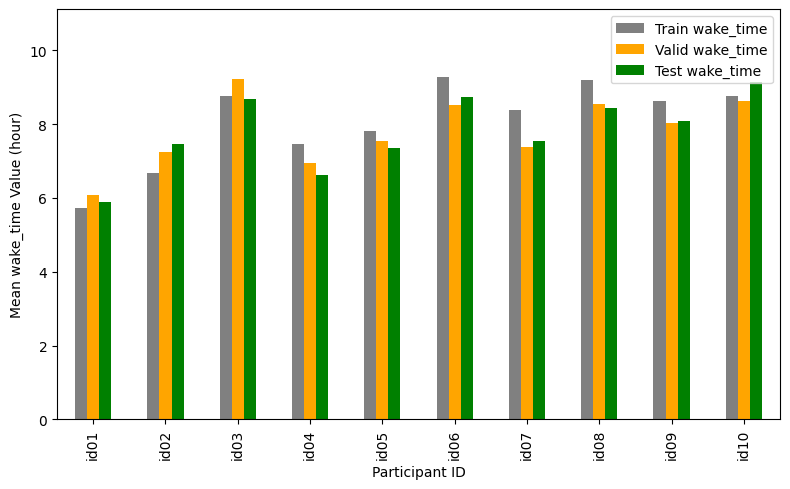

In [45]:
compare_means2(train2, valid2, test, 'subject_id', 'wake_time')

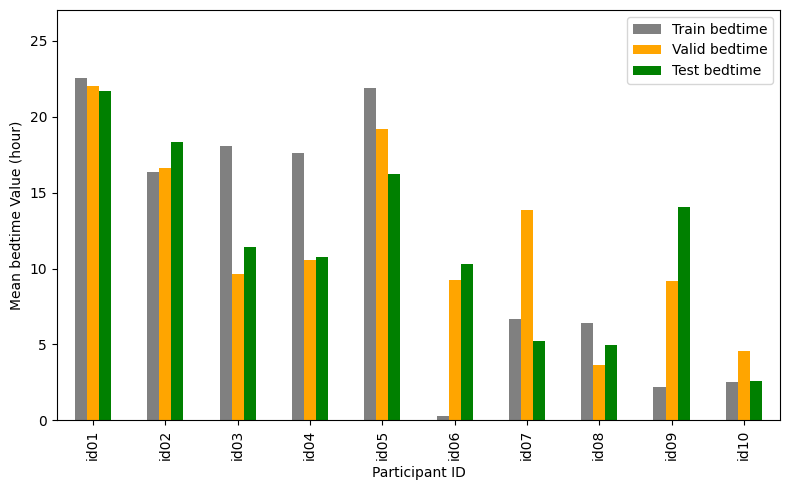

In [46]:
compare_means2(train2, valid2, test, 'subject_id', 'bedtime')